In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import transform
from functools import partial
import pyproj
import cartopy.crs as ccrs
import rtree as rt
import warnings
warnings.filterwarnings('ignore')

In [2]:
P1 = Point(-46.727823, -23.483424)
P2 = Point(-46.727676, -23.483632)
PM = Point((P1.x+P2.x)/2, (P1.y+P2.y)/2)

In [3]:
def calc_haversine_distance(point1, point2, earth_radius=6373.0):
    lon1, lat1 = point1.x, point1.y
    lon2, lat2 = point2.x, point2.y
    
    rlat1 = np.radians(lat1)
    rlat2 = np.radians(lat2)

    rlon1 = np.radians(lon1)
    rlon2 = np.radians(lon2)

    dlon = rlon2-rlon1
    dlat = rlat2-rlat1

    a = np.sin(dlat / 2)**2 + np.cos(rlat1) * np.cos(rlat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return earth_radius * c


def calc_azimuth_angle(point1, point2):
    lon1, lat1 = point1.x, point1.y
    lon2, lat2 = point2.x, point2.y
    
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    dl = np.radians(lon2 - lon1)

    x = np.sin(dl)*np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - (np.sin(lat1)*np.cos(lat2)*np.cos(dl))

    initial_bearing = np.degrees(np.arctan2(x, y))
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


def calc_buffer_area_from_point(point, km):
    lon, lat = point.x, point.y
    
    proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84
    )
    buf = Point(0, 0).buffer(km*1000)

    return transform(project, buf).exterior.coords[:]


def load_and_prepare_data(filename, sep=';', lat_name='dat_latitude', lon_name='dat_longitude', datetime_name='data'):
    gdf = pd.read_csv(filename, sep=sep)
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.points_from_xy(x=gdf.dat_longitude, y=gdf.dat_latitude)
    ).drop([lon_name, lat_name], axis=1)
    gdf[datetime_name] = pd.to_datetime(gdf[datetime_name], format='%Y-%m-%d %H:%M:%S')
    
    return gdf


def filter_area_data(gdf, area):
    rtree = rt.index.Index()
    for i, row in gdf.iterrows():
        rtree.insert(i, row['geometry'].bounds)
        
    sindex_matches = list(rtree.intersection(area.bounds))
    points_matches = gdf.iloc[sindex_matches]
    gdf = points_matches[points_matches.intersects(area)]
    
    return gdf

def add_spatial_info_columns(gdf):
    gdf['distance_km'] = gdf.apply(
        lambda row: calc_haversine_distance(P2, row['geometry']),
        axis=1
    )

    gdf['azimuth_angle'] = gdf.apply(
        lambda row: calc_azimuth_angle(P2, row['geometry']),
        axis=1
    )
    
    return gdf

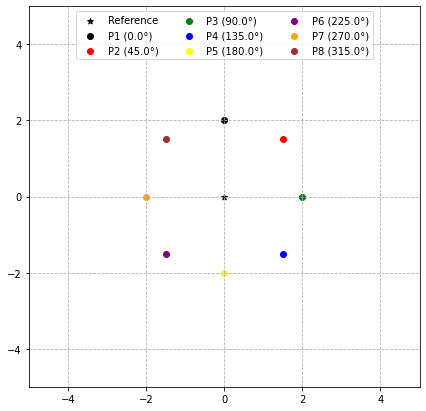

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
ax.grid(ls='--')

ref = Point(0, 0)
p1 = Point(0, 2)
p2 = Point(1.5, 1.5)
p3 = Point(2, 0)
p4 = Point(1.5, -1.5)
p5 = Point(0, -2)
p6 = Point(-1.5, -1.5)
p7 = Point(-2, 0)
p8 = Point(-1.5, 1.5)

ap1 = calc_azimuth_angle(ref, p1)
ap2 = calc_azimuth_angle(ref, p2)
ap3 = calc_azimuth_angle(ref, p3)
ap4 = calc_azimuth_angle(ref, p4)
ap5 = calc_azimuth_angle(ref, p5)
ap6 = calc_azimuth_angle(ref, p6)
ap7 = calc_azimuth_angle(ref, p7)
ap8 = calc_azimuth_angle(ref, p8)

ax.scatter(ref.x, ref.y, marker='*', color='k', label='Reference')
ax.scatter(p1.x, p1.y, color='k', label=f'P1 ({ap1:.1f}°)')
ax.scatter(p2.x, p2.y, color='r', label=f'P2 ({ap2:.1f}°)')
ax.scatter(p3.x, p3.y, color='g', label=f'P3 ({ap3:.1f}°)')
ax.scatter(p4.x, p4.y, color='b', label=f'P4 ({ap4:.1f}°)')
ax.scatter(p5.x, p5.y, color='yellow', label=f'P5 ({ap5:.1f}°)')
ax.scatter(p6.x, p6.y, color='purple', label=f'P6 ({ap6:.1f}°)')
ax.scatter(p7.x, p7.y, color='orange', label=f'P7 ({ap7:.1f}°)')
ax.scatter(p8.x, p8.y, color='brown', label=f'P8 ({ap8:.1f}°)')

ax.legend(ncol=3, loc='upper center')

In [5]:
sp_mesh = gpd.read_file("../data/shapefiles/sao_paulo_municipal_mesh.shp")
sp_mesh.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,3500105,Adamantina,SP,411.987,"POLYGON ((-51.05425 -21.40465, -51.05300 -21.4..."
1,3500204,Adolfo,SP,211.055,"POLYGON ((-49.65795 -21.20333, -49.65645 -21.2..."
2,3500303,Aguaí,SP,474.554,"POLYGON ((-46.97640 -21.96818, -46.97599 -21.9..."
3,3500402,Águas da Prata,SP,142.673,"POLYGON ((-46.73501 -21.81891, -46.73431 -21.8..."
4,3500501,Águas de Lindóia,SP,60.126,"POLYGON ((-46.60614 -22.44173, -46.60347 -22.4..."


In [6]:
buffer_area = calc_buffer_area_from_point(P2, 7)
circle_area = Polygon(list((x, y) for x, y in buffer_area))

margin = 0.01
bounds = circle_area.bounds
bounds = (bounds[0]-margin, bounds[2]+margin, bounds[1]-margin, bounds[3]+margin)

In [7]:
brasildat_df = load_and_prepare_data(filename="../data/lightning_sensors/brasildat/brasildat_20190124.txt")
brasildat_df = filter_area_data(brasildat_df, circle_area)
brasildat_df = add_spatial_info_columns(brasildat_df)
brasildat_df.head()

,data,dat_nanosegundo,dat_corrente_pico_ka,dat_semieixo_maior,dat_azimute_elipse,dat_flag_intranuvem,geometry,distance_km,azimuth_angle
96605,2019-01-24 17:16:11,224590688,-19,1.0,82,0,POINT (-46.69880 -23.43820),5.849597,30.249835
116011,2019-01-24 17:34:06,539656128,-14,1.0,81,0,POINT (-46.69850 -23.43740),5.941920,30.072777
115004,2019-01-24 17:33:16,837758208,-14,0.7,144,0,POINT (-46.68940 -23.43540),6.635855,36.061673
106044,2019-01-24 17:25:00,916909696,-5,0.3,71,1,POINT (-46.69960 -23.43360),6.259132,27.244080
112976,2019-01-24 17:31:32,571717056,-17,1.1,35,0,POINT (-46.69240 -23.43310),6.674420,32.642306


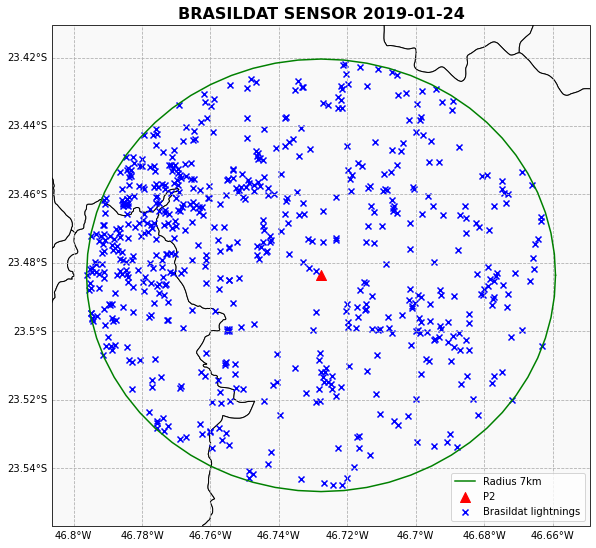

In [8]:
dpi = 100
width = np.round(1366 * 130 / 100)/dpi
height = (768 * 1.2)/dpi

fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor='w', subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_geometries(sp_mesh.geometry, ccrs.PlateCarree(), zorder=1, fc='#f9f9f9', ec='k', lw=1)
ax.set_extent(bounds, ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax.set_title('BRASILDAT SENSOR 2019-01-24', fontdict=dict(weight='bold', size=16))
ax.scatter([P2.x], [P2.y], c='red', s=100, marker='^', zorder=2, label='P2')
ax.plot(*circle_area.exterior.xy, c='green', label='Radius 7km')
brasildat_df.plot(ax=ax, c='b', marker='x', zorder=2, label='Brasildat lightnings')

ax.legend(loc='lower right')

plt.savefig(
    f'../results/map_brasildat.png', dpi=dpi, fc='w', bbox_inches='tight',
    transparent=False, pad_inches=0.1
)

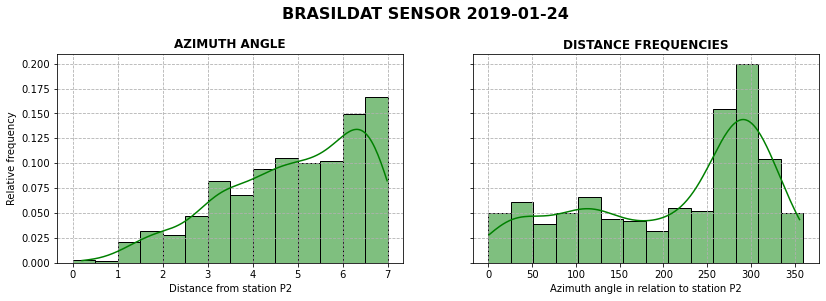

In [9]:
dpi = 100
width = np.round(1366 * 100 / 100)/dpi
height = (768 * 0.5)/dpi

fig, ax = plt.subplots(1, 2, figsize=(width, height), facecolor='w', sharey=True)

sns.histplot(
    brasildat_df['distance_km'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 7, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax[0]
)

sns.histplot(
    brasildat_df['azimuth_angle'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 360, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax[1]
)

fig.suptitle('BRASILDAT SENSOR 2019-01-24', weight='bold', size=16, y=1.05)
ax[0].set_title('AZIMUTH ANGLE', fontdict=dict(weight='bold'))
ax[0].set_ylabel('Relative frequency')
ax[0].set_xlabel('Distance from station P2')
ax[0].grid(ls='--')

ax[1].set_title('DISTANCE FREQUENCIES', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Azimuth angle in relation to station P2')
ax[1].grid(ls='--')


plt.savefig(
    f'../results/histograms_brasildat.png', dpi=dpi, fc='w', bbox_inches='tight',
    transparent=False, pad_inches=0.1
)

In [10]:
rindatin_df = load_and_prepare_data(filename="../data/lightning_sensors/rindat/rindat_in_20190124.txt")
rindatin_df = filter_area_data(rindatin_df, circle_area)
# rindatin_df = add_spatial_info_columns(rindatin_df)
rindatin_df.head()

,data,dat_nanosegundo,dat_corrente_pico_ka,dat_semieixo_maior,dat_azimute_elipse,geometry


In [11]:
rindatns_df = load_and_prepare_data(filename="../data/lightning_sensors/rindat/rindat_ns_20190124.txt")
rindatns_df = filter_area_data(rindatns_df, circle_area)
rindatns_df = add_spatial_info_columns(rindatns_df)
rindatns_df.head()

,data,dat_nanosegundo,dat_corrente_pico_ka,dat_semieixo_maior,dat_azimute_elipse,geometry,distance_km,azimuth_angle
4053,2019-01-24 17:39:14,251598693,-25,3.4,169.6,POINT (-46.73790 -23.46100),2.724913,337.490380
4496,2019-01-24 17:50:20,451586251,-38,0.4,171.2,POINT (-46.73750 -23.44160),4.781461,347.896907
3329,2019-01-24 17:19:20,222507478,-44,3.4,169.6,POINT (-46.70310 -23.45410),4.132492,37.360877
3582,2019-01-24 17:26:21,594748973,-34,3.4,169.6,POINT (-46.70010 -23.46820),3.295682,58.617376
4192,2019-01-24 17:43:08,758923711,-37,3.4,169.6,POINT (-46.69250 -23.46060),4.409424,54.486573


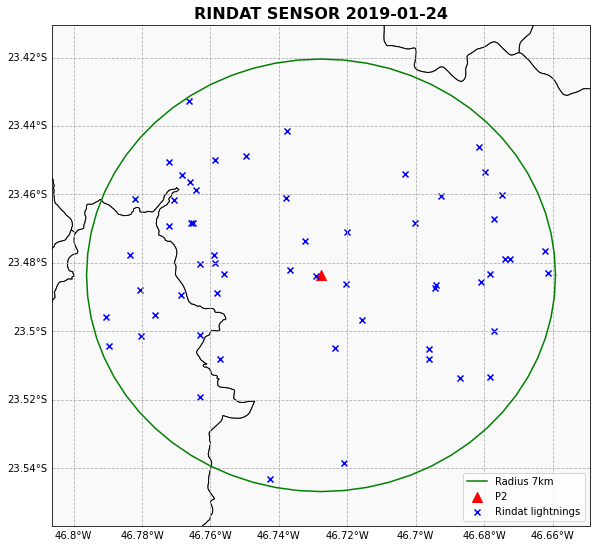

In [12]:
dpi = 100
width = np.round(1366 * 130 / 100)/dpi
height = (768 * 1.2)/dpi

fig, ax = plt.subplots(1, 1, figsize=(width, height), facecolor='w', subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_geometries(sp_mesh.geometry, ccrs.PlateCarree(), zorder=1, fc='#f9f9f9', ec='k', lw=1)
ax.set_extent(bounds, ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax.set_title('RINDAT SENSOR 2019-01-24', fontdict=dict(weight='bold', size=16))
ax.scatter([P2.x], [P2.y], c='red', s=100, marker='^', zorder=2, label='P2')
ax.plot(*circle_area.exterior.xy, c='green', label='Radius 7km')
rindatns_df.plot(ax=ax, c='b', marker='x', zorder=2, label='Rindat lightnings')

ax.legend(loc='lower right')


plt.savefig(
    f'../results/map_rindat.png', dpi=dpi, fc='w', bbox_inches='tight',
    transparent=False, pad_inches=0.1
)

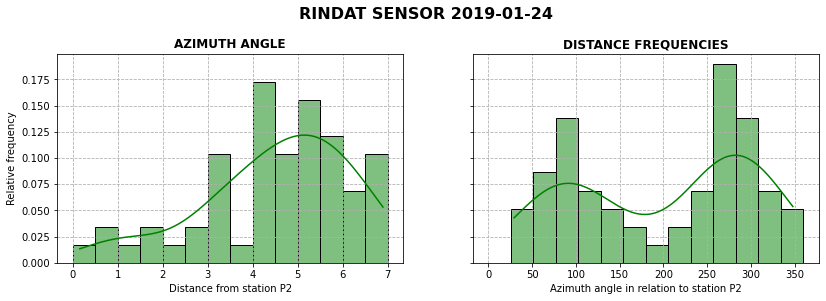

In [13]:
dpi = 100
width = np.round(1366 * 100 / 100)/dpi
height = (768 * 0.5)/dpi

fig, ax = plt.subplots(1, 2, figsize=(width, height), facecolor='w', sharey=True)

sns.histplot(
    rindatns_df['distance_km'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 7, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax[0]
)

sns.histplot(
    rindatns_df['azimuth_angle'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 360, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax[1]
)

fig.suptitle('RINDAT SENSOR 2019-01-24', weight='bold', size=16, y=1.05)
ax[0].set_title('AZIMUTH ANGLE', fontdict=dict(weight='bold'))
ax[0].set_ylabel('Relative frequency')
ax[0].set_xlabel('Distance from station P2')
ax[0].grid(ls='--')

ax[1].set_title('DISTANCE FREQUENCIES', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Azimuth angle in relation to station P2')
ax[1].grid(ls='--')

plt.savefig(
    f'../results/histograms_rindat.png', dpi=dpi, fc='w', bbox_inches='tight',
    transparent=False, pad_inches=0.1
)

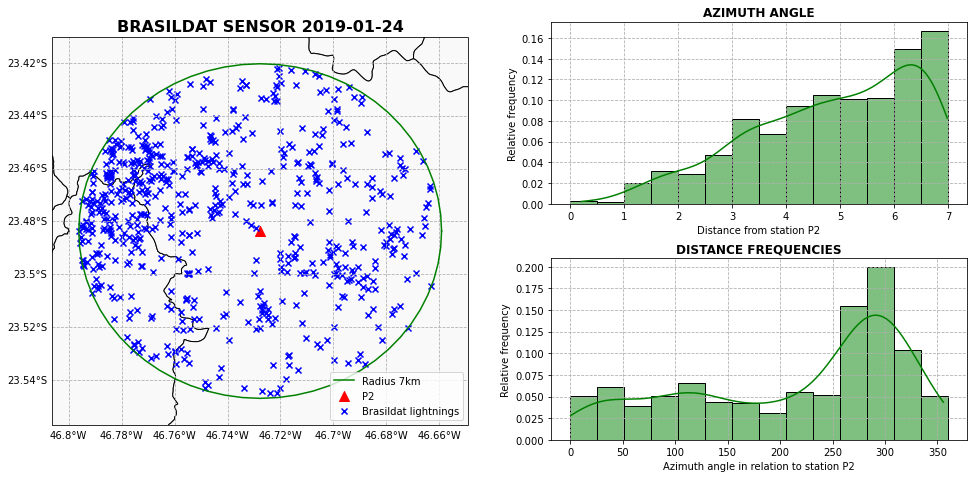

In [14]:
dpi = 100
width = np.round(1366 * 120 / 100)/dpi
height = (768 * 1)/dpi

fig = plt.figure(figsize=(width, height), facecolor='w')
gs = GridSpec(nrows=2, ncols=2)

ax1 = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.add_geometries(sp_mesh.geometry, ccrs.PlateCarree(), zorder=1, fc='#f9f9f9', ec='k', lw=1)
ax1.set_extent(bounds, ccrs.PlateCarree())

gl = ax1.gridlines(draw_labels=True, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax1.set_title('BRASILDAT SENSOR 2019-01-24', fontdict=dict(weight='bold', size=16))
ax1.scatter([P2.x], [P2.y], c='red', s=100, marker='^', zorder=2, label='P2')
ax1.plot(*circle_area.exterior.xy, c='green', label='Radius 7km')
brasildat_df.plot(ax=ax1, c='b', marker='x', zorder=2, label='Brasildat lightnings')
ax1.legend(loc='lower right')


ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(
    brasildat_df['distance_km'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 7, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax2
)

ax2.set_title('AZIMUTH ANGLE', fontdict=dict(weight='bold'))
ax2.set_ylabel('Relative frequency')
ax2.set_xlabel('Distance from station P2')
ax2.grid(ls='--')


ax3 = fig.add_subplot(gs[1, 1])
sns.histplot(
    brasildat_df['azimuth_angle'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 360, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax3
)
ax3.set_title('DISTANCE FREQUENCIES', fontdict=dict(weight='bold'))
ax3.set_ylabel('Relative frequency')
ax3.set_xlabel('Azimuth angle in relation to station P2')
ax3.grid(ls='--')

plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig(
    f'../results/complete_plot_brasildat.png', dpi=dpi, fc='w', bbox_inches='tight',
    transparent=False, pad_inches=0.1
)

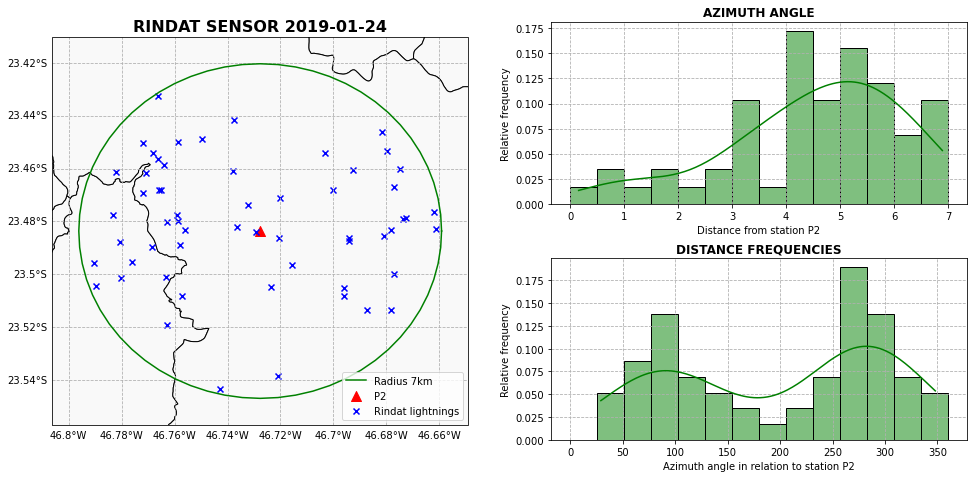

In [15]:
dpi = 100
width = np.round(1366 * 120 / 100)/dpi
height = (768 * 1)/dpi

fig = plt.figure(figsize=(width, height), facecolor='w')
gs = GridSpec(nrows=2, ncols=2)

ax1 = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.add_geometries(sp_mesh.geometry, ccrs.PlateCarree(), zorder=1, fc='#f9f9f9', ec='k', lw=1)
ax1.set_extent(bounds, ccrs.PlateCarree())

gl = ax1.gridlines(draw_labels=True, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax1.set_title('RINDAT SENSOR 2019-01-24', fontdict=dict(weight='bold', size=16))
ax1.scatter([P2.x], [P2.y], c='red', s=100, marker='^', zorder=2, label='P2')
ax1.plot(*circle_area.exterior.xy, c='green', label='Radius 7km')
rindatns_df.plot(ax=ax1, c='b', marker='x', zorder=2, label='Rindat lightnings')
ax1.legend(loc='lower right')


ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(
    rindatns_df['distance_km'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 7, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax2
)
# fig.suptitle('RINDAT SENSOR 2019-01-24', weight='bold', size=16, y=1.05)
ax2.set_title('AZIMUTH ANGLE', fontdict=dict(weight='bold'))
ax2.set_ylabel('Relative frequency')
ax2.set_xlabel('Distance from station P2')
ax2.grid(ls='--')


ax3 = fig.add_subplot(gs[1, 1])
sns.histplot(
    rindatns_df['azimuth_angle'].values,
    log_scale=False,
    stat="probability", 
    color='green', 
    alpha=0.5,
    bins=np.linspace(0, 360, 15),
    kde=True,
    edgecolor="k", linewidth=1,
    ax=ax3
)
ax3.set_title('DISTANCE FREQUENCIES', fontdict=dict(weight='bold'))
ax3.set_ylabel('Relative frequency')
ax3.set_xlabel('Azimuth angle in relation to station P2')
ax3.grid(ls='--')

plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig(
    f'../results/complete_plot_rindat.png', dpi=dpi, fc='w', bbox_inches='tight',
    transparent=False, pad_inches=0.1
)

In [17]:
brasildat_df['data'] = brasildat_df['data'].dt.strftime('%Y-%m-%d %H:%M:%S')
rindatns_df['data'] = rindatns_df['data'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [18]:
brasildat_df.to_file(filename= "../data/shapefiles/new-brasildat.shp", driver='ESRI Shapefile')
rindatns_df.to_file(driver='ESRI Shapefile', filename= "../data/shapefiles/new-rindat.shp")